# Build your own neos!

In [13]:
from __future__ import annotations

import jax
import jax.numpy as jnp
from jax.random import PRNGKey, multivariate_normal
import pyhf
from typing import Callable, Any, Generator, Iterable
from functools import partial
import matplotlib.pyplot as plt
import neos

jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

# # matplotlib settings
# plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.style.use("thesis-style.mplstyle")
Array = jnp.ndarray

## Preamble
`neos` tackles the problem of learning optimal summary statistics from data. The workflow is explained in more detail [in our paper]() -- this notebook is designed to get you up-and-running with how that workflow looks in code, including how to do this for your own use-case! (if you want to do that for real, please reach out -- we'd love to help you!)

To construct this kind of workflow, you need to specify three things:
- How to construct your summary statistic from data
- How to build your likelihood function from that summary statistic
- A choice of metric relating to how you deem your analysis to be "optimal"

The second bullet in-particular is very important; while we've abstracted away all the technical detail, `neos` is still not a drop-in loss function in the typical sense, since it requires *detailed information from the analyser on how to build the likelihood*. No longer do we have a problem-agnostic notion of "signal" and "background"; instead, we're wanting to optimise our specific problem, so we need to provide specific information. That is how `neos` is "systematic-aware" -- it's a technique that explicitly takes into account how your systematics are modelled. But to do this, we of course need to model them in the first place!

Here, we're going to re-implement the example from the paper with 2-dimensional Gaussian blobs making up our data. We have a nominal estimate for signal and background data, and we also provide "up" and "down" variations that correspond to moving the mean of the background blob. The helper function to generate this dataset is below:

### Dataset generation helper function + visualisation

In [14]:
def generate_data(
    rng: int = 0,
    num_points: int = 10000,
    sig_mean: tuple[float, float] = (-1, 1),
    bup_mean: tuple[float, float] = (2.5, 2),
    bdown_mean: tuple[float, float] = (-2.5, -1.5),
    b_mean: tuple[float, float] = (1, -1),
) -> tuple[Array, Array, Array, Array]:
    sig = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(sig_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_up = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bup_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_down = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bdown_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )

    bkg_nom = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(b_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    return sig, bkg_nom, bkg_up, bkg_down


data = generate_data()

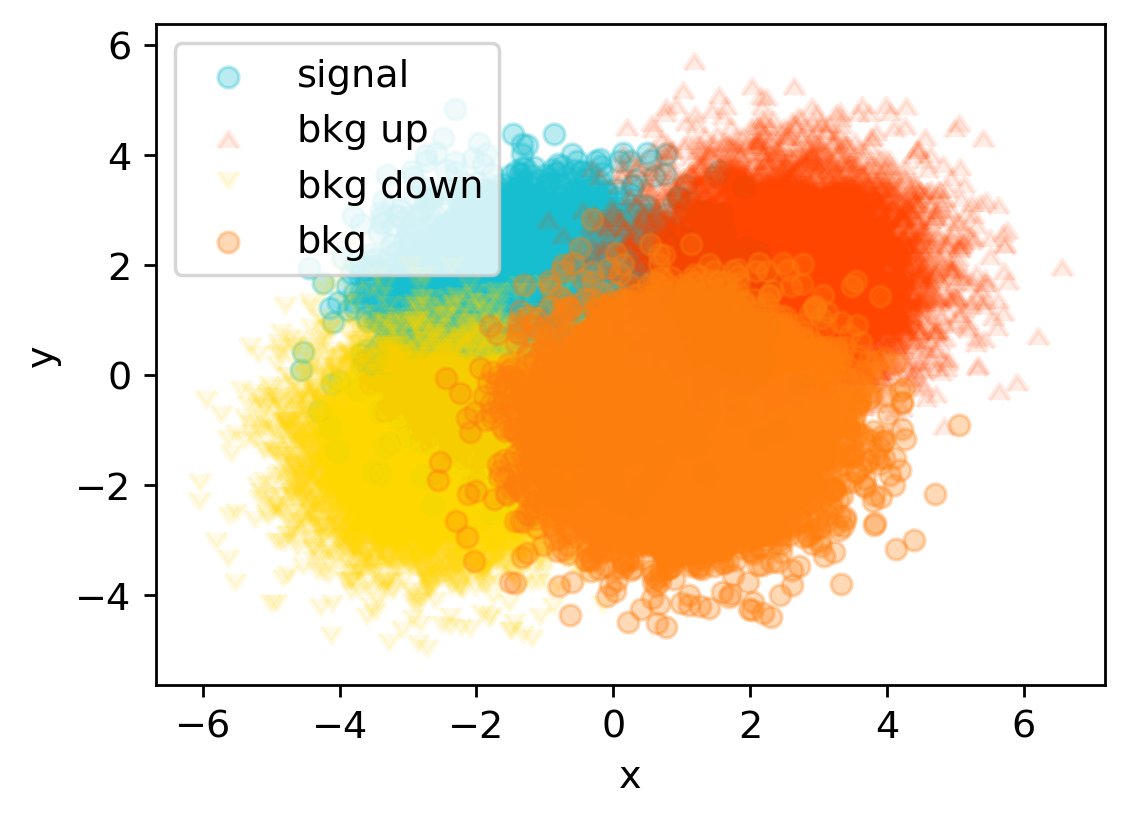

In [15]:
def plot_data_space(
    ax: Any,
    data: Array,
    params: dict[str, Any] | None = None,
    nn: Callable | None = None,
    bins: Array | None = None,
) -> None:
    if nn is not None:
        network = params["nn_pars"]
        bins = params["bins"] if "bins" in params else bins
        g = jnp.mgrid[-10:10:101j, -10:10:101j]
        levels = [0, *bins, 1]
        ax.contourf(
            g[0],
            g[1],
            nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
            levels=levels,
            cmap="binary",
        )
        ax.contour(
            g[0],
            g[1],
            nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
            colors="w",
            levels=levels,
        )
    sig, bkg_nom, bkg_up, bkg_down = data
    # should definitely not have to repeat this every time lmao
    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9", label="signal")
    ax.scatter(
        bkg_up[:, 0],
        bkg_up[:, 1],
        alpha=0.1,
        c="orangered",
        marker=6,
        label="bkg up",
    )
    ax.scatter(
        bkg_down[:, 0],
        bkg_down[:, 1],
        alpha=0.1,
        c="gold",
        marker=7,
        label="bkg down",
    )
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1", label="bkg")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()


fig, ax = plt.subplots()
plot_data_space(ax, data)

Now that we have our data, we need to specify how we construct our summary statistic. We will use a neural network for this, left unspecified until later. Since our likelihood modelling stage will later involve using histograms, we'll also construct a histogram of the output, then scale the yields in each batch for a more "realistic" analysis. This step is wrapped up in a simple convenience function called `neos.hists_from_nn`, which we'll use in a moment.

After this comes the problem-specific part: the likelihood model construction. I mentioned before that we have "up" and "down" datasets -- this is a typical construct in HEP that we use to model the effect of physical parameters. We will then have three histograms for the background data: one for each of the nominal, up, and down samples. The HistFactory prescription for building likelihood functions then models the uncertainty between these by interpolating between their yields. Luckily, this is done under the hood for us in `pyhf` -- we just need to write a dictionary specifying the format of our histograms. This can be found below for our case, where we describe our uncertainty by forming a nuisance parameter `"correlated_bkg_uncertainty"` that modifies the shape of the histogram in a bin-correlated fashion. 

### Physicist's input: how to build your statistical model from histograms 

In [16]:
# assume we give a dict of histograms with keys "sig", "bkg_nominal", "bkg_up", "bkg_down".
def model_from_hists(hists: dict[str, Array]) -> pyhf.Model:
    """How to make your HistFactory model from your histograms."""
    spec = {
        "channels": [
            {
                "name": "singlechannel",  # we only have one "channel" (data region)
                "samples": [
                    {
                        "name": "signal",
                        "data": hists["sig"],  # signal
                        "modifiers": [
                            {
                                "name": "mu",
                                "type": "normfactor",
                                "data": None,
                            },  # our signal strength modifier (parameter of interest)
                        ],
                    },
                    {
                        "name": "background",
                        "data": hists["bkg_nominal"],  # background
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {
                                    "hi_data": hists["bkg_up"],  # up sample
                                    "lo_data": hists["bkg_down"],  # down sample
                                },
                            },
                        ],
                    },
                ],
            },
        ],
    }
    return pyhf.Model(spec, validate=False)

Now we just have to form our metric of choice from our likelihood model. Here, we have a variety to choose from: uncertainty on the signal strength modifier (cross-section), discovery significance, CLs, even the classic binary cross-entropy (that doesn't use the likelihood at all). Instead of overloading the notebook with losses, I've baked them all into `neos.loss_from_model`, which takes in a `pyhf` model and a string with the metric you want to calculate.

With these ingredients, we just need to compose them in one function, so we can take the gradient of that function with respect to our free parameters:

### Build pipeline by combining functions from the `neos` module with our model builder

In [22]:
def pipeline(
    pars: dict[str, Array],
    data: tuple[Array, ...],
    nn: Callable,
    loss: str,
    bandwidth: float,
    sample_names: Iterable[str],  # we're using a list of dict keys for bookkeeping!
    scale_factors: dict[str, float],
    bins: Array | None = None,  # in case you don't want to optimise binning
    lumi: float = 10.0,  # overall scale factor
) -> float:
    # zip up our data arrays with the corresponding sample names
    data_dct = {k: v for k, v in zip(sample_names, data)}

    # if you want s/b discrimination, no need to do anything complex!
    if loss.lower() in ["bce", "binary cross-entropy"]:
        return neos.losses.bce(data=data_dct, pars=pars["nn_pars"], nn=nn)

    # use a neural network + differentiable histograms [bKDEs] to get the yields
    hists = neos.hists_from_nn(
        pars=pars["nn_pars"],
        nn=nn,
        data=data_dct,
        bandwidth=bandwidth,  # for the bKDEs
        bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
        scale_factors=scale_factors,
        overall_scale=lumi,
    )
    hists = {k:v+1e-1 for k,v in hists.items()}  # no empty bins

    # build our statistical model, and calculate the loss!
    model = model_from_hists(hists)
    return neos.loss_from_model(model, loss=loss)

Below is now mostly training boilerplate! I'll add titles, but should be mostly clear what's going on (ask if not!)

### Initialise network architecture + params

In [23]:
from jax.experimental import stax

rng_state = 0  # random state

# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

num_features = 2
_, init = init_random_params(PRNGKey(rng_state), (-1, num_features))
init_pars = dict(nn_pars=init)

### Define batching mechanism for data

In [24]:
from sklearn.model_selection import train_test_split
import numpy.random as npr

batch_size = 4000  # change me if you want!
split = train_test_split(*data, random_state=rng_state)
train, test = split[::2], split[1::2]


def batches(training_data: Array, batch_size: int) -> Generator:
    num_train = training_data[0].shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism, ripped from the JAX docs :)
    def data_stream():
        rng = npr.RandomState(rng_state)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield [points[batch_idx] for points in train]

    return data_stream()


batch_iterator = batches(train, batch_size)

### Training loop definition


In [25]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter


def run_optimisation(
    num_steps: int,
    objective: str,
    test_objective: str,
    lr: float,
    bins: Array,
    data_types: Iterable[str],
    scale_factors: dict[str, float],
    include_bins: bool = True,
) -> tuple[Array, dict[str, list]]:

    loss = partial(
        pipeline,
        nn=nn,
        sample_names=data_types,
        scale_factors=scales,
    )

    solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

    pyhf.set_backend("jax", default=True)

    if include_bins:
        init_pars["bins"] = bins[
            1:-1
        ]  # don't want to float endpoints [will account for kde spill]
        state = solver.init_state(init_pars)
    else:
        if "bins" in init_pars:
            del init_pars["bins"]
        state = solver.init_state(init_pars)

    params = init_pars
    best_params = init_pars
    best_sig = 999
    metrics = {k: [] for k in ["cls", "discovery", "poi_uncert", "loss", "bce"]}

    for i in range(num_steps):
        print(f"step {i}: loss={objective}")
        data = next(batch_iterator)
        start = perf_counter()
        params, state = solver.update(
            params, state, bins=bins, data=data, loss=objective, bandwidth=9e-2
        )
        end = perf_counter()
        print(f"update took {end-start:.4g}s")
        if "bins" in params:
            print("bin edges: [0 ", *[f"{f:.3g}" for f in params["bins"]], " 1]")
        for metric in metrics:
            if metric != "loss":
                test_metric = loss(
                    params, bins=bins, data=test, loss=metric, bandwidth=1e-8
                )
                print(f"{metric}={test_metric:.4g}")
                metrics[metric].append(test_metric)
            else:
                metrics["loss"].append(loss(params, bins=bins, data=data, loss=objective, bandwidth=9e-2))
        if metrics["discovery"][-1] < best_sig:
            best_params = params
            best_sig = metrics["discovery"][-1]
        print()
    return best_params, metrics

### Run!

In [31]:
include_bins = True  # simultaneously optimise binning and neural net!
num_bins = 5
bins = jnp.linspace(0, 1, num_bins + 1)  # keep in [0,1] if using sigmoid activation
lr = 1e-3
num_steps = 100


# the same keys you used in the model building step [model_from_hists]
data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
scales = {k: 2.0 if k == "sig" else 10.0 for k in data_types}

# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
def run_neos(setting):
    objective = test_metric = setting
    return run_optimisation(
        num_steps, objective, test_metric, lr, bins, data_types, scales, include_bins
    )



settings = ["bce", "poi_uncert", "CLs", "discovery"]
all_pars = {k:None for k in settings}
all_metrics = {k:None for k in settings}
for setting in settings:
    pars, metrics = run_neos(setting)
    all_pars[setting] = pars
    all_metrics[setting] = metrics

step 0: loss=bce
update took 0.9305s
bin edges: [0  0.2 0.4 0.6 0.8  1]
cls=0.01689
discovery=0.01302
poi_uncert=0.4924
bce=0.759

step 1: loss=bce
update took 1.009s
bin edges: [0  0.2 0.4 0.6 0.8  1]
cls=0.02294
discovery=0.009226
poi_uncert=0.4902
bce=0.7177

step 2: loss=bce
update took 0.7856s
bin edges: [0  0.2 0.4 0.6 0.8  1]
cls=0.02274
discovery=0.002552
poi_uncert=0.4196
bce=0.6981

step 3: loss=bce
update took 0.9024s
bin edges: [0  0.2 0.4 0.6 0.8  1]
cls=0.01845
discovery=0.0004921
poi_uncert=0.374
bce=0.6868

step 4: loss=bce
update took 0.8805s
bin edges: [0  0.2 0.4 0.6 0.8  1]
cls=0.007222
discovery=5.569e-05
poi_uncert=0.3444
bce=0.6788

step 5: loss=bce
update took 0.915s
bin edges: [0  0.2 0.4 0.6 0.8  1]
cls=0.0006169
discovery=7.573e-07
poi_uncert=0.3157
bce=0.6718

step 6: loss=bce
update took 0.8721s
bin edges: [0  0.2 0.4 0.6 0.8  1]
cls=0.000182
discovery=4.494e-08
poi_uncert=0.305
bce=0.665

step 7: loss=bce
update took 0.9874s
bin edges: [0  0.2 0.4 0.6 0.8 

## Random visualisations!

### Metrics

In [78]:
batch_size

256

In [ ]:

epoch_grid = (jnp.array(list(range(1, num_steps + 1))) * batch_size) / train[0].shape[0]
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(
    [
        ["bce", "poi_uncert"],
        ["CLs", "image"],
    ],
)
colors = ["C0", "C1", "C9", "C4"]
for i, (k, v) in enumerate(all_metrics.items()):
    ax_dict[k].plot(epoch_grid, v)


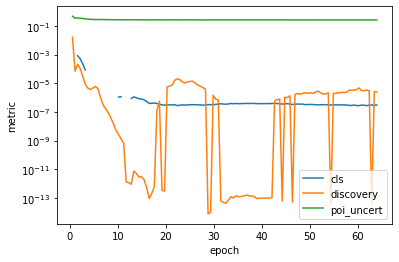

In [10]:
import matplotlib.pyplot as plt

epoch_grid = (jnp.array(list(range(1, num_steps + 1))) * batch_size) / train[0].shape[0]
for k, v in metrics.items():
    if k != "loss":
        plt.plot(epoch_grid, v, label=k)
plt.yscale("log")
# plt.ylim((2.5e-8, 1))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("metric")
plt.savefig("float.png")

In [24]:
OptaxSolver(lambda x: x, opt=optax.adam(lr), jit=True).init_state()

TypeError: init_state() missing 1 required positional argument: 'init_params'

### Histograms

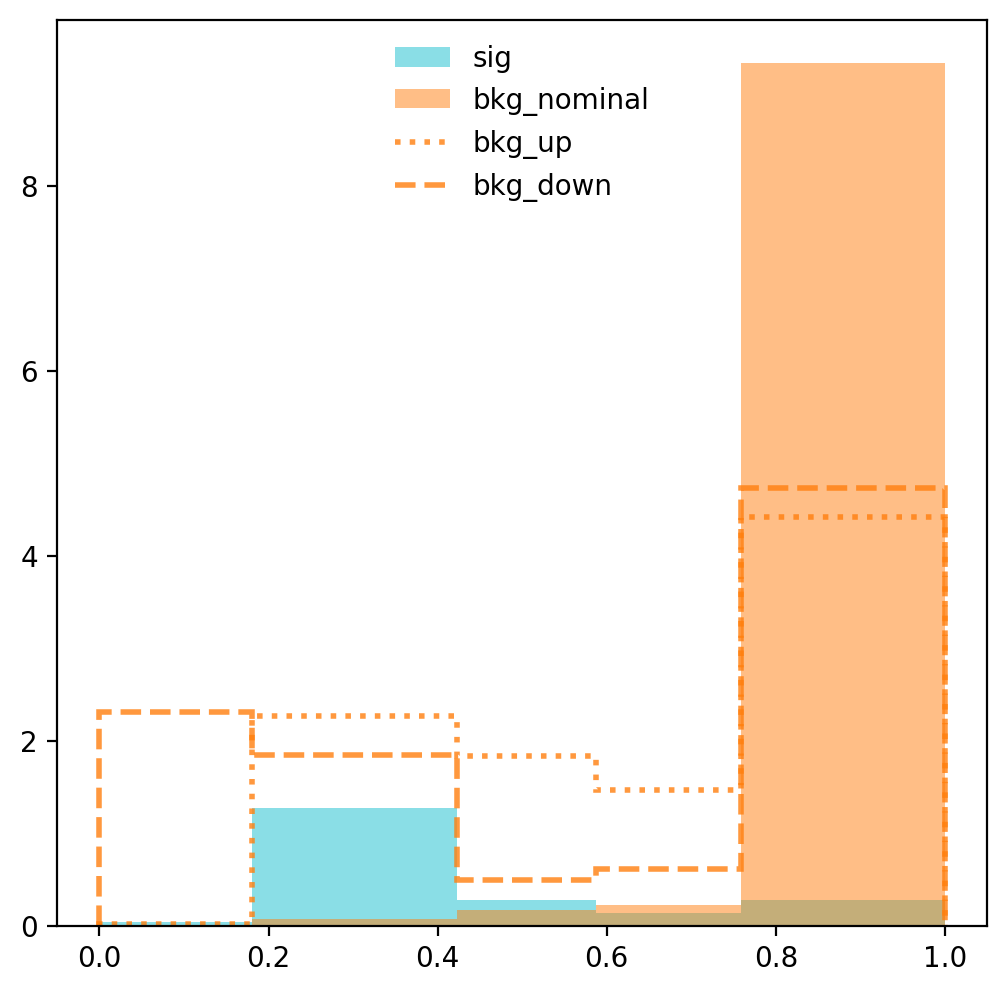

In [76]:
yields = neos.hists_from_nn(
    best_params["nn_pars"],
    {k: v for k, v in zip(data_types, test)},
    nn,
    bandwidth=1e-8,
    scale_factors={k: 2.0 if k == "sig" else 10.0 for k in data_types},
    bins=jnp.array([0, *best_params["bins"], 1]),
)
binning = jnp.array([0, *best_params["bins"], 1])
names, counts = list(yields.keys()), list(yields.values())
plt.stairs(counts[0], binning, label=names[0], alpha=0.5, color='C9', fill=True)
plt.stairs(counts[1], binning, label=names[1], alpha=0.5, color='C1', fill=True)
plt.stairs(counts[2], binning, label=names[2], alpha=0.8, fill=None, edgecolor='C1', linewidth=2, linestyle="dotted")
plt.stairs(counts[3], binning, label=names[3], alpha=0.8, fill=None, edgecolor='C1', linewidth=2, linestyle="dashed")

plt.legend(loc="upper center", frameon=False)
plt.savefig("uhist.png")

In [ ]:
binning

DeviceArray([0.        , 0.20204074, 0.39691649, 0.59155381, 0.79008264,
             1.        ], dtype=float64)

### Neural network contours (only relevant for the blobs problem)

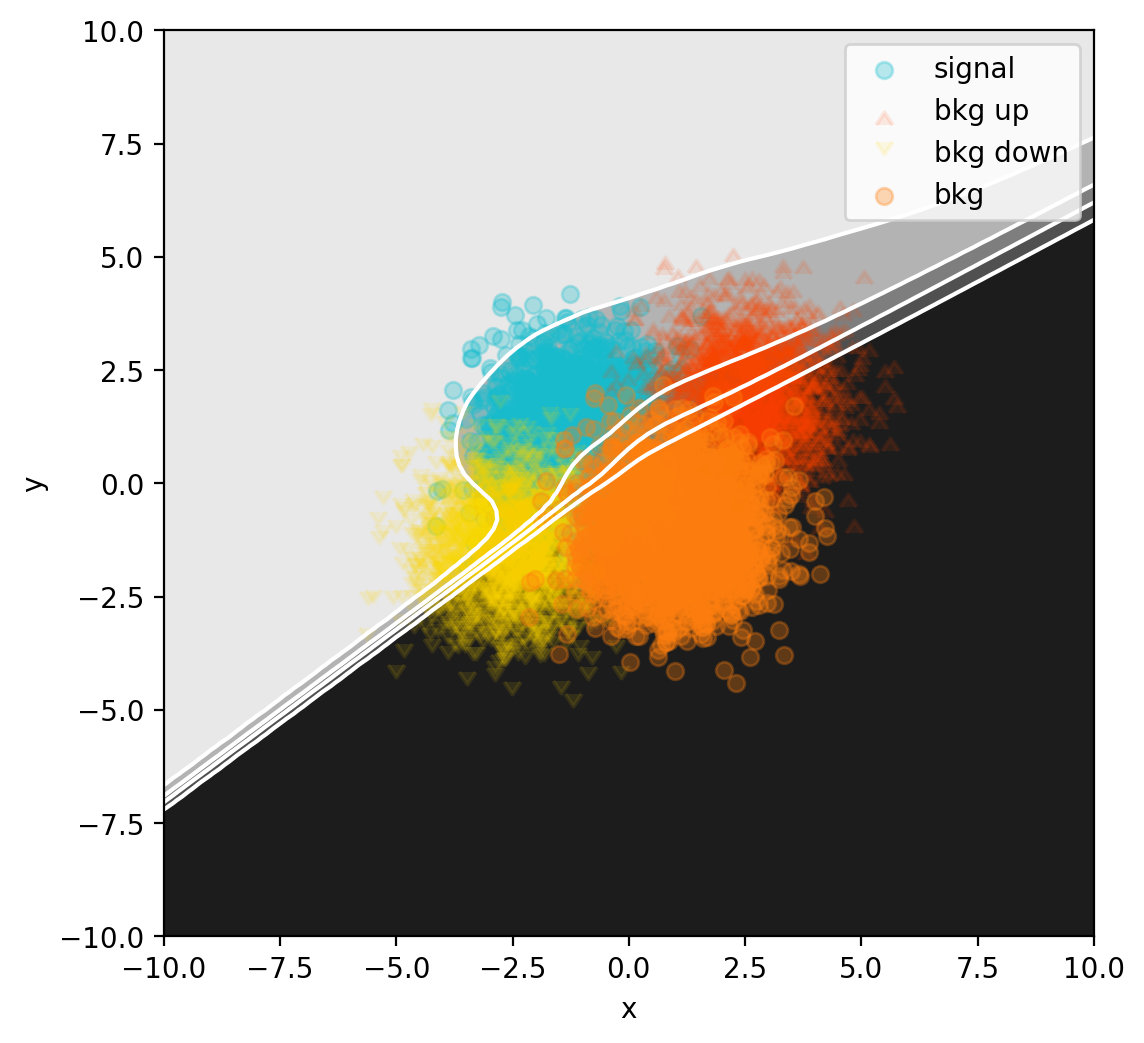

In [11]:
plt.rc("figure", figsize=(6, 6), dpi=200, facecolor="w")

fig, ax = plt.subplots()
plot_data_space(ax, test, best_params, nn=nn)
plt.savefig("udataspace.png")

## More hacky way of doing the same thing
The above pipeline is actually limited by the fact that we've only got `pyhf` to construct models differentiably for this particular systematic type -- there are currently some technical roadblocks to doing it for others.

One way to circumvent this is to just hack the model structure itself, because all we care about is the likelhood, and that uses class attributes to calculate it. We'll have to make a copy of the model each time so we don't mutate the global state of the program (`jax` hates when you do this), but it's possible, albeit a bit cumbersome to write. 

(apologies in advance if you read the code -- let's discuss if you want to do this!)

In [ ]:
from copy import deepcopy


def hacked_pipeline(
    pars: dict[str, Array],
    data: tuple[Array, ...],
    nn: Callable,
    loss: str | Callable,
    bandwidth: float,
    sample_names: Iterable,
    skeleton_model: pyhf.Model,  # new argument: dummy model with random yields
    scale_factors: dict[str, float],
    bins: Array | None = None,
    lumi: float = 10.0,
) -> float:
    data_dct = {k: v for k, v in zip(sample_names, data)}
    if loss.lower() in ["bce", "binary cross-entropy"]:
        return neos.losses.bce(data=data_dct, pars=pars["nn_pars"], nn=nn)
    hists = neos.hists_from_nn(
        pars=pars["nn_pars"],
        nn=nn,
        data=data_dct,
        bandwidth=bandwidth,
        bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
        scale_factors=scale_factors,
        overall_scale=lumi,
    )
    # NB: below is a way to hack your model with yield information so you don't have
    # to go through all the pyhf boilerplate when taking gradients.
    # This could be the more realistic way to do this if you want to do it *now* for an
    # arbitrary model that we haven't tested.
    # to start: make a copy of a dummy model with the same spec as your real model
    model = deepcopy(skeleton_model)

    # the model yields are in two places in our case:
    #   - the nominal sig + bkg yields
    #   - the up/down/nominal templates for the systematic [histosys],
    #     located in the interpolation settings
    # => we find these attributes, and hack in our calculated values from the nn.
    #
    # start by getting the infromation on the interpolator type:
    interpcode = model.main_model.modifiers_appliers["histosys"].interpcode
    interp_maker = getattr(pyhf.interpolators, interpcode)

    # then we update the model in-place with the new nominal and template information:
    def model_update_from_hists(hists):
        nominal_rates = jnp.stack([hists["bkg_nominal"], hists["sig"]]).reshape(
            model.main_model.nominal_rates.shape
        )
        histoset = [
            [
                [hists["bkg_down"], hists["bkg_nominal"], hists["bkg_up"]],
                [hists["sig"]] * 3,
            ]
        ]

        return nominal_rates, histoset

    def update_model(new_nominal, new_histoset):
        model.main_model.nominal_rates = new_nominal
        interpolator = interp_maker(new_histoset)
        model.main_model.modifiers_appliers["histosys"].interpolator = interpolator

    update_model(*model_update_from_hists(hists))

    # back to normal code...
    return neos.loss_from_model(model, loss=loss)

In [ ]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter

include_bins = True
num_bins = 4
bins = jnp.linspace(0, 1, num_bins + 1)  # keep in [0,1] if using sigmoid activation
lr = 1e-3
num_steps = 20
# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
objective = "cls"
keep_metric = "discovery"

# the same keys you used in the model building step [model_from_hists]
data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
scales = {k: 2.0 if k == "sig" else 10.0 for k in data_types}
loss = partial(
    hacked_pipeline,
    nn=nn,
    sample_names=data_types,
    scale_factors=scales,
    skeleton_model=model_from_hists(
        {k: v for k, v in zip(data_types, [jnp.ones(num_bins)] * 4)}
    ),
)

jax.jit(loss, static_argnames=("loss"))

solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

pyhf.set_backend("jax", default=True)

if include_bins:
    init_pars["bins"] = bins[
        1:-1
    ]  # don't want to float endpoints [will account for kde spill]
    state = solver.init_state(init_pars)
else:
    if "bins" in init_pars:
        del init_pars["bins"]
    state = solver.init_state(init_pars)

params = init_pars
best_params = init_pars
best_sig = 999
metrics = {k: [] for k in ["cls", "discovery", "poi_uncert"]}

for i in range(num_steps):
    print(f"step {i}: loss={objective}")
    data = next(batch_iterator)
    start = perf_counter()
    params, state = solver.update(
        params, state, bins=bins, data=data, loss=objective, bandwidth=9e-2
    )
    end = perf_counter()
    print(f"update took {end-start:.4g}s")
    if "bins" in params:
        print("bin edges: [0 ", *[f"{f:.3g}" for f in params["bins"]], " 1]")
    for metric in metrics:
        test_metric = loss(params, bins=bins, data=test, loss=metric, bandwidth=1e-8)
        print(f"{metric}={test_metric:.4g}")
        metrics[metric].append(test_metric)
    if metrics["discovery"][-1] < best_sig:
        best_params = params
        best_sig = metrics["discovery"][-1]
    print()

step 0: loss=cls


/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


update took 2.506s
bin edges: [0  0.251 0.501 0.749  1]
cls=0.003912
discovery=0.009824
poi_uncert=0.4526

step 1: loss=cls
update took 2.477s
bin edges: [0  0.252 0.5 0.748  1]
cls=9.274e-06
discovery=0.008902
poi_uncert=0.4859

step 2: loss=cls
update took 2.473s
bin edges: [0  0.252 0.5 0.748  1]
cls=1.447e-06
discovery=0.002055
poi_uncert=0.4358

step 3: loss=cls
update took 3.282s
bin edges: [0  0.253 0.499 0.747  1]
cls=9.776e-07
discovery=0.0009045
poi_uncert=0.3611

step 4: loss=cls
update took 2.485s
bin edges: [0  0.253 0.499 0.747  1]
cls=1.111e-06
discovery=0.0006624
poi_uncert=0.3007

step 5: loss=cls
update took 2.432s
bin edges: [0  0.254 0.498 0.747  1]
cls=1.268e-06
discovery=0.0007909
poi_uncert=0.2642

step 6: loss=cls
update took 2.436s
bin edges: [0  0.254 0.498 0.747  1]
cls=1.432e-06
discovery=0.002224
poi_uncert=0.27

step 7: loss=cls
update took 3.096s
bin edges: [0  0.254 0.498 0.746  1]
cls=1.807e-06
discovery=0.002976
poi_uncert=0.2939

step 8: loss=cls
upda

In [ ]:
best_sig

DeviceArray(0.00066241, dtype=float64)